<a href="https://colab.research.google.com/github/lilyzhizhou/Datathon-5/blob/main/Datathon_5_LSTM_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import warnings
import torch as t
import torch.nn as nn
import random
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

np.random.seed(42)

In [2]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if t.cuda.is_available()
    else "mps"
    if t.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
# Load in data
# data = pd.read_csv('/content/drive/MyDrive/Machine Learning /Datathon #5/mhealth.csv')
data = pd.read_csv('mhealth.csv')

# drop subject 9 bc their distribution is different from the others
data = data[data['subject'] != 'subject9']

print(data.shape)
data.head()

(982273, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,2.1849,-9.6967,0.63077,0.103900,-0.84053,-0.68762,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,0,subject1
1,2.3876,-9.5080,0.68389,0.085343,-0.83865,-0.68369,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,0,subject1
2,2.4086,-9.5674,0.68113,0.085343,-0.83865,-0.68369,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,0,subject1
3,2.1814,-9.4301,0.55031,0.085343,-0.83865,-0.68369,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,0,subject1
4,2.4173,-9.3889,0.71098,0.085343,-0.83865,-0.68369,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,0,subject1


In [5]:
data.dtypes

alx         float64
aly         float64
alz         float64
glx         float64
gly         float64
glz         float64
arx         float64
ary         float64
arz         float64
grx         float64
gry         float64
grz         float64
Activity      int64
subject      object
dtype: object

Split into Training and Testing


---



In [6]:
# Grouping by 'subject' and creating a list of dataframes, one per group
grouped = data.groupby('subject')
grouped_data = [group for _, group in grouped]

# Splitting the groups into training and test sets with an 80:20 ratio
train_groups, test_groups = train_test_split(grouped_data, test_size=0.2, random_state=42)

# Reassembling the training and test datasets from the groups
train_df = pd.concat(train_groups)
test_df = pd.concat(test_groups)

# Displaying the shape of the training and test sets
train_df_shape = train_df.shape
test_df_shape = test_df.shape

train_df_shape, test_df_shape

((753408, 14), (228865, 14))

In [7]:
# train_df.head()
test_df.head()

,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
161280,0.49965,-9.6680,1.5216,-0.47866,-0.53471,0.53438,-4.6451,-8.2508,1.9208,-0.98039,-0.41889,0.18966,0,subject2
161281,0.40572,-9.5801,1.4001,-0.48423,-0.54409,0.52652,-4.7847,-8.2609,1.9099,-0.98039,-0.41889,0.18966,0,subject2
161282,0.42741,-9.6488,1.4593,-0.48423,-0.54409,0.52652,-4.4974,-8.3198,2.0215,-0.97647,-0.42094,0.20043,0,subject2
161283,0.32193,-9.4522,1.3119,-0.48423,-0.54409,0.52652,-4.6902,-8.4318,1.8180,-0.97647,-0.42094,0.20043,0,subject2
161284,0.46731,-9.6397,1.3769,-0.49165,-0.52345,0.51866,-4.7595,-8.4420,1.7966,-0.97647,-0.42094,0.20043,0,subject2


Normalization

---



In [8]:
# Identifying numerical columns (excluding 'subject' and 'Activity')
numerical_columns = train_df.select_dtypes(include=['float64']).columns.tolist()

# Initializing the StandardScaler
scaler = StandardScaler()

# Fitting the scaler to the training data and transforming both training and test data
train_df[numerical_columns] = scaler.fit_transform(train_df[numerical_columns])
test_df[numerical_columns] = scaler.transform(test_df[numerical_columns])

# Checking the first few rows of the normalized training data
print(train_df.shape)
train_df.head()

(753408, 14)


,alx,aly,alz,glx,gly,glz,arx,ary,arz,grx,gry,grz,Activity,subject
0,0.214821,-0.022355,0.309939,0.244241,-0.668159,-1.036175,-1.098917,0.233330,-0.594683,-0.335191,-1.016340,-0.471094,0,subject1
1,0.267516,0.023418,0.319902,0.207517,-0.662733,-1.028975,-1.094306,0.278958,-0.636633,-0.335191,-1.016340,-0.471094,0,subject1
2,0.272975,0.009010,0.319384,0.207517,-0.662733,-1.028975,-1.069191,0.286484,-0.572206,-0.335191,-1.016340,-0.471094,0,subject1
3,0.213911,0.042315,0.294847,0.207517,-0.662733,-1.028975,-1.094388,0.279577,-0.548748,-0.349689,-1.012564,-0.486675,0,subject1
4,0.275237,0.052309,0.324983,0.207517,-0.662733,-1.028975,-1.109395,0.309677,-0.538585,-0.349689,-1.012564,-0.486675,0,subject1


Sequence Creation & Addressing Class Imbalance

---



In [9]:
# Sequence creation for data (with undersampling for train data)
sensor_columns = ['alx','aly','alz','glx','gly','glz','arx','ary','arz','grx','gry','grz']

def create_sequences(data, sequence_length=100, train = True):
    sequences = []
    output = []
    for i in range(0, len(data) - sequence_length + 1, sequence_length):
        sequence = data[i:i + sequence_length]
        # We label the sequence with the most intense activity within the sequence
        label = sequence['Activity'].max()

        # Undersampling label 0 for train data only
        if train == False or (label != 0 or random.random() > 0.95): # undersample the 0 labels where there is a 95% chance to drop
          sequences.append(sequence[sensor_columns].values)
          output.append(label)

    return np.array(sequences), np.array(output)

# Creating sequences for training and test data
X_train, y_train = create_sequences(train_df, sequence_length=100, train = True)
X_test, y_test = create_sequences(test_df, sequence_length=100, train = False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2411, 100, 12), (2411,), (2288, 100, 12), (2288,))

<Axes: ylabel='Count'>

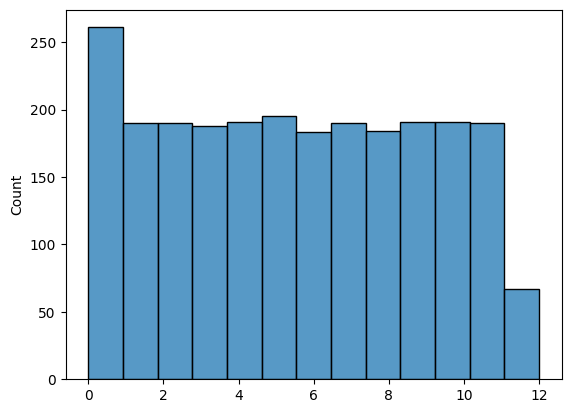

In [10]:
import seaborn as sns
# for i in range(len(y_train)):
#   print(y_train[i])

sns.histplot(y_train)

Training data looks more balanced now

Run LSTM Model

---



- will need to tune parameters
- not sure what to set as hidden_size

In [11]:
class lstmModel(nn.Module): # Model inherits from nn.Module
    def __init__(self, input_size, hidden_dim, num_classes):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_dim, batch_first=True) # LSTM layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, num_classes)
        )
        
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out.max(1)[0])
        return nn.functional.log_softmax(out, dim=1)

In [12]:
def modelLoop(epochs, hidden_dim, learning_rate, batch_size):

    # Data preparation
    train_dataset = TensorDataset(t.Tensor(X_train).type(t.float32).to(device), t.Tensor(y_train).type(t.float32).to(device))
    train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    test_dataset = TensorDataset(t.Tensor(X_test).type(t.float32).to(device), t.Tensor(y_test).type(t.float32).to(device))
    test_data_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Model
    model = lstmModel(input_size=12, hidden_dim = hidden_dim, num_classes = 13).to(device)

    # Loss function and optimizer
    loss_fn = nn.CrossEntropyLoss()
    optimizer = t.optim.Adam(model.parameters(), lr=learning_rate)

    # Lists to store accuracies and losses
    train_accuracy_list = []
    validation_accuracy_list = []
    train_loss_list = []

    # Training loop
    for epoch in range(epochs):
        # if epoch % 10 == 0:
        #     learning_rate *= 0.9  # Learning rate scheduling

        per_epoch_loss_list = []

        # Setting Model to train mode
        model.train()

        for X, Y in train_data_loader:
            Y = Y.type(t.LongTensor)   # casting to long
            X = X.type(t.float32)   # casting to long
            X, Y = X.to(device), Y.to(device)
            # Forward pass through layers
            pred = model(X)
            loss = loss_fn(pred, Y)

            per_epoch_loss_list.append(loss.item())

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # Evaluation on training and validation data
        model.eval()
        
        with t.no_grad():
            # Training data
            train_correct, train_total = 0, 0
            for X, Y in train_data_loader:
                y_pred = model(X)
                _, predicted = t.max(y_pred, dim=1)
                train_total += Y.size(0)
                train_correct += (predicted == Y).sum().item()

            train_accuracy = 100 * train_correct / train_total

            # Validation data
            validation_correct, validation_total = 0, 0
            for X, Y in test_data_loader:
                y_pred = model(X)
                _, predicted = t.max(y_pred, dim=1)
                validation_total += Y.size(0)
                validation_correct += (predicted == Y).sum().item()
            validation_accuracy = 100 * validation_correct / validation_total

            # Print accuracy for the current epoch
            print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}%, Validation Accuracy: {validation_accuracy}%')

            # Append accuracy values to lists
            train_accuracy_list.append(train_accuracy)
            validation_accuracy_list.append(validation_accuracy)

            # Calculate and append the average loss for the epoch
            train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

    return train_accuracy_list, validation_accuracy_list
    

- Not sure if we want only the last output of the sequence if we initially generated it using the max
(out = out[:, -1, :])

- Using the last observation of sequence: Train Accuracy: 68.8%, Validation Accuracy: 27.4%
- Using max observation of sequence Train Accuracy: 95.8%, Validation Accuracy: 56.4%

In [13]:
    
def plot_acc(train_accuracy_list, validation_accuracy_list):
    # Plot training and validation accuracy over epochs
    plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
    plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
    plt.legend(loc="upper left")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

Batch Size: 128, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 6.055578598092078%, Validation Accuracy: 3.977272727272727%
Epoch 1/100 ---> Train Accuracy: 18.125259228535878%, Validation Accuracy: 12.84965034965035%
Epoch 2/100 ---> Train Accuracy: 30.111986727498962%, Validation Accuracy: 18.924825174825173%
Epoch 3/100 ---> Train Accuracy: 41.02032351721277%, Validation Accuracy: 22.377622377622377%
Epoch 4/100 ---> Train Accuracy: 46.16341766901701%, Validation Accuracy: 21.284965034965033%
Epoch 5/100 ---> Train Accuracy: 52.094566569888016%, Validation Accuracy: 19.973776223776223%
Epoch 6/100 ---> Train Accuracy: 58.8137702198258%, Validation Accuracy: 19.012237762237763%
Epoch 7/100 ---> Train Accuracy: 64.99377851513894%, Validation Accuracy: 19.361888111888113%
Epoch 8/100 ---> Train Accuracy: 67.31646619659892%, Validation Accuracy: 19.318181818181817%
Epoch 9/100 ---> Train Accuracy: 68.35338034010783%, Validation Accuracy: 18.181818181818183%
Epoch 

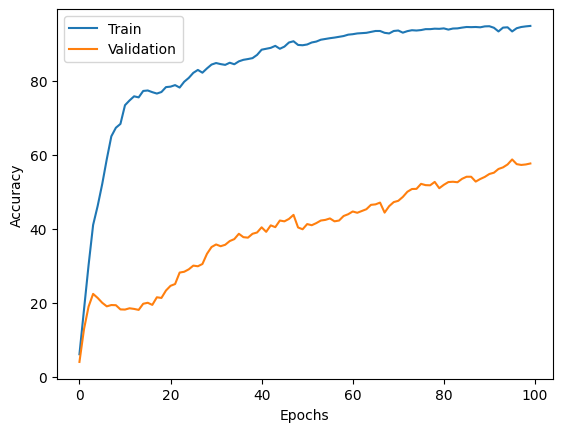

Batch Size: 128, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 25.964330153463294%, Validation Accuracy: 35.31468531468531%
Epoch 1/100 ---> Train Accuracy: 50.72583990045624%, Validation Accuracy: 45.93531468531469%
Epoch 2/100 ---> Train Accuracy: 54.7905433430112%, Validation Accuracy: 39.33566433566433%
Epoch 3/100 ---> Train Accuracy: 57.237660721692244%, Validation Accuracy: 38.8986013986014%
Epoch 4/100 ---> Train Accuracy: 62.671090833678974%, Validation Accuracy: 39.24825174825175%
Epoch 5/100 ---> Train Accuracy: 66.98465367067607%, Validation Accuracy: 35.97027972027972%
Epoch 6/100 ---> Train Accuracy: 72.08627125673995%, Validation Accuracy: 31.206293706293707%
Epoch 7/100 ---> Train Accuracy: 78.97138116963916%, Validation Accuracy: 28.54020979020979%
Epoch 8/100 ---> Train Accuracy: 81.9991704686852%, Validation Accuracy: 30.638111888111887%
Epoch 9/100 ---> Train Accuracy: 83.82413936126089%, Validation Accuracy: 33.3479020979021%
Epoch 10/100 --

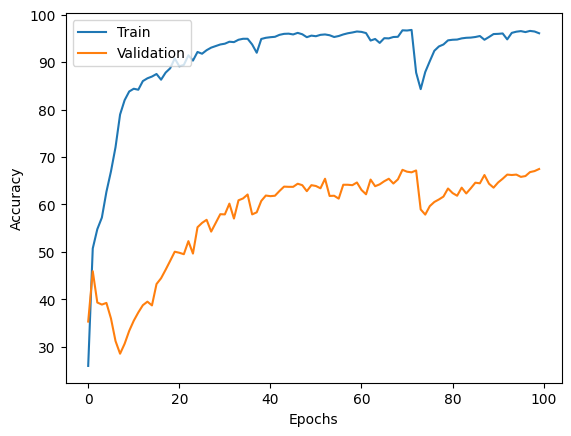

Batch Size: 128, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 43.0111986727499%, Validation Accuracy: 21.896853146853147%
Epoch 1/100 ---> Train Accuracy: 46.37080049771879%, Validation Accuracy: 13.854895104895105%
Epoch 2/100 ---> Train Accuracy: 51.76275404396516%, Validation Accuracy: 15.20979020979021%
Epoch 3/100 ---> Train Accuracy: 55.86893405226047%, Validation Accuracy: 19.187062937062937%
Epoch 4/100 ---> Train Accuracy: 68.18747407714642%, Validation Accuracy: 25.21853146853147%
Epoch 5/100 ---> Train Accuracy: 76.77312318540025%, Validation Accuracy: 26.748251748251747%
Epoch 6/100 ---> Train Accuracy: 81.87474077146412%, Validation Accuracy: 30.76923076923077%
Epoch 7/100 ---> Train Accuracy: 82.82870178349232%, Validation Accuracy: 28.88986013986014%
Epoch 8/100 ---> Train Accuracy: 83.82413936126089%, Validation Accuracy: 34.35314685314685%
Epoch 9/100 ---> Train Accuracy: 86.89340522604728%, Validation Accuracy: 37.15034965034965%
Epoch 10/100 

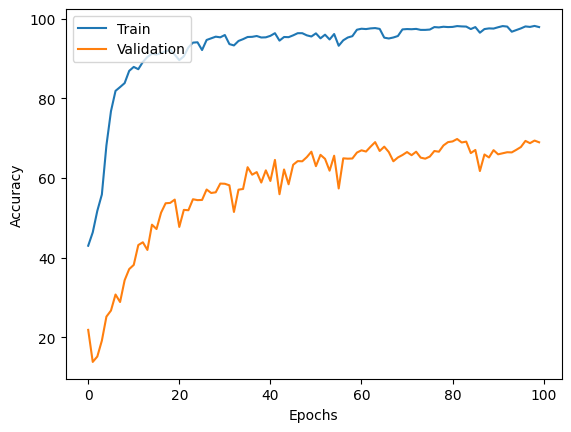

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 50.60141020323517%, Validation Accuracy: 19.973776223776223%
Epoch 1/100 ---> Train Accuracy: 69.51472418083783%, Validation Accuracy: 20.27972027972028%
Epoch 2/100 ---> Train Accuracy: 76.98050601410203%, Validation Accuracy: 23.732517482517483%
Epoch 3/100 ---> Train Accuracy: 80.5474906677727%, Validation Accuracy: 32.6486013986014%
Epoch 4/100 ---> Train Accuracy: 85.77353795105765%, Validation Accuracy: 40.16608391608391%
Epoch 5/100 ---> Train Accuracy: 88.05474906677728%, Validation Accuracy: 46.89685314685315%
Epoch 6/100 ---> Train Accuracy: 91.08253836582331%, Validation Accuracy: 52.40384615384615%
Epoch 7/100 ---> Train Accuracy: 92.78307756117793%, Validation Accuracy: 55.59440559440559%
Epoch 8/100 ---> Train Accuracy: 91.6632102861883%, Validation Accuracy: 54.41433566433567%
Epoch 9/100 ---> Train Accuracy: 93.28079635006222%, Validation Accuracy: 59.7027972027972%
Epoch 10/100 ---> T

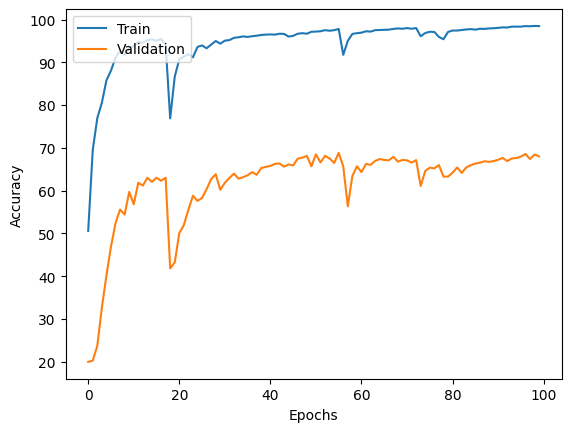

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 65.49149730402323%, Validation Accuracy: 19.755244755244757%
Epoch 1/100 ---> Train Accuracy: 83.99004562422232%, Validation Accuracy: 33.39160839160839%
Epoch 2/100 ---> Train Accuracy: 86.72749896308585%, Validation Accuracy: 46.41608391608391%
Epoch 3/100 ---> Train Accuracy: 91.3728743260058%, Validation Accuracy: 53.97727272727273%
Epoch 4/100 ---> Train Accuracy: 92.74160099543758%, Validation Accuracy: 58.04195804195804%
Epoch 5/100 ---> Train Accuracy: 95.14724180837827%, Validation Accuracy: 64.72902097902097%
Epoch 6/100 ---> Train Accuracy: 94.48361675653256%, Validation Accuracy: 68.22552447552448%
Epoch 7/100 ---> Train Accuracy: 95.64496059726255%, Validation Accuracy: 69.71153846153847%
Epoch 8/100 ---> Train Accuracy: 96.47449191206968%, Validation Accuracy: 71.45979020979021%
Epoch 9/100 ---> Train Accuracy: 96.01824968892576%, Validation Accuracy: 72.02797202797203%
Epoch 10/100 --->

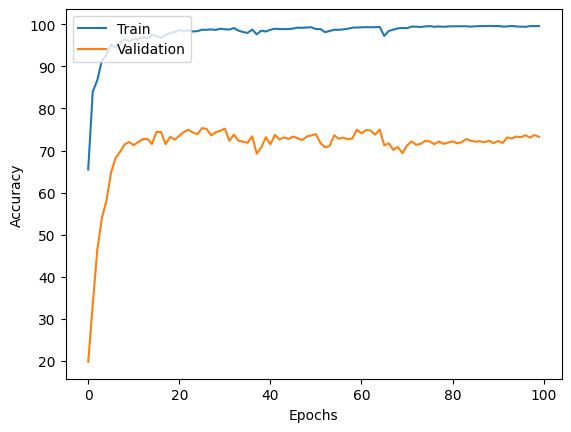

Batch Size: 128, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 78.26627955205309%, Validation Accuracy: 33.21678321678322%
Epoch 1/100 ---> Train Accuracy: 89.09166321028619%, Validation Accuracy: 47.37762237762238%
Epoch 2/100 ---> Train Accuracy: 92.5342181667358%, Validation Accuracy: 57.69230769230769%
Epoch 3/100 ---> Train Accuracy: 94.23475736209042%, Validation Accuracy: 60.27097902097902%
Epoch 4/100 ---> Train Accuracy: 95.10576524263791%, Validation Accuracy: 65.73426573426573%
Epoch 5/100 ---> Train Accuracy: 96.01824968892576%, Validation Accuracy: 66.6520979020979%
Epoch 6/100 ---> Train Accuracy: 96.2671090833679%, Validation Accuracy: 68.7062937062937%
Epoch 7/100 ---> Train Accuracy: 96.68187474077146%, Validation Accuracy: 70.93531468531468%
Epoch 8/100 ---> Train Accuracy: 97.05516383243467%, Validation Accuracy: 69.62412587412588%
Epoch 9/100 ---> Train Accuracy: 96.97221070095397%, Validation Accuracy: 71.24125874125875%
Epoch 10/100 ---> Tra

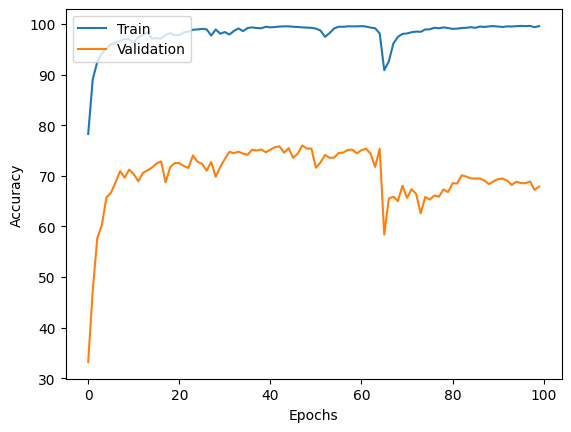

Batch Size: 128, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 86.52011613438407%, Validation Accuracy: 43.70629370629371%
Epoch 1/100 ---> Train Accuracy: 91.04106180008296%, Validation Accuracy: 55.59440559440559%
Epoch 2/100 ---> Train Accuracy: 92.2438822065533%, Validation Accuracy: 53.75874125874126%
Epoch 3/100 ---> Train Accuracy: 94.19328079635007%, Validation Accuracy: 60.05244755244755%
Epoch 4/100 ---> Train Accuracy: 96.18415595188718%, Validation Accuracy: 65.2972027972028%
Epoch 5/100 ---> Train Accuracy: 95.89381999170469%, Validation Accuracy: 66.60839160839161%
Epoch 6/100 ---> Train Accuracy: 93.98589796764828%, Validation Accuracy: 62.89335664335665%
Epoch 7/100 ---> Train Accuracy: 95.52053090004148%, Validation Accuracy: 69.88636363636364%
Epoch 8/100 ---> Train Accuracy: 94.52509332227291%, Validation Accuracy: 63.02447552447553%
Epoch 9/100 ---> Train Accuracy: 94.3591870593115%, Validation Accuracy: 61.49475524475525%
Epoch 10/100 ---> Tra

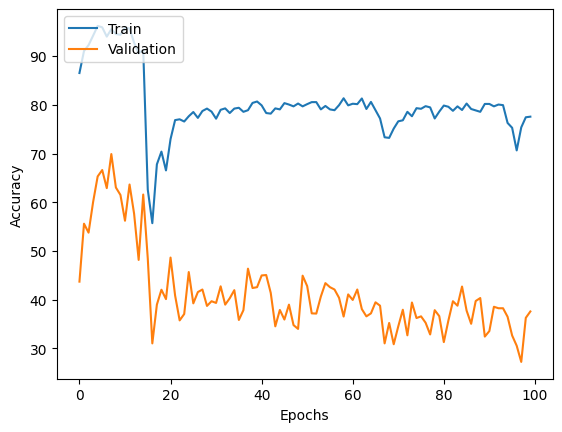

Batch Size: 128, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 84.23890501866445%, Validation Accuracy: 61.27622377622377%
Epoch 1/100 ---> Train Accuracy: 93.15636665284114%, Validation Accuracy: 56.90559440559441%
Epoch 2/100 ---> Train Accuracy: 92.74160099543758%, Validation Accuracy: 66.17132867132867%
Epoch 3/100 ---> Train Accuracy: 94.60804645375363%, Validation Accuracy: 67.04545454545455%
Epoch 4/100 ---> Train Accuracy: 96.10120282040647%, Validation Accuracy: 70.23601398601399%
Epoch 5/100 ---> Train Accuracy: 95.76939029448361%, Validation Accuracy: 64.81643356643356%
Epoch 6/100 ---> Train Accuracy: 94.11032766486935%, Validation Accuracy: 61.97552447552447%
Epoch 7/100 ---> Train Accuracy: 93.77851513894649%, Validation Accuracy: 68.35664335664336%
Epoch 8/100 ---> Train Accuracy: 95.0228121111572%, Validation Accuracy: 64.68531468531468%
Epoch 9/100 ---> Train Accuracy: 94.60804645375363%, Validation Accuracy: 54.89510489510489%
Epoch 10/100 ---> T

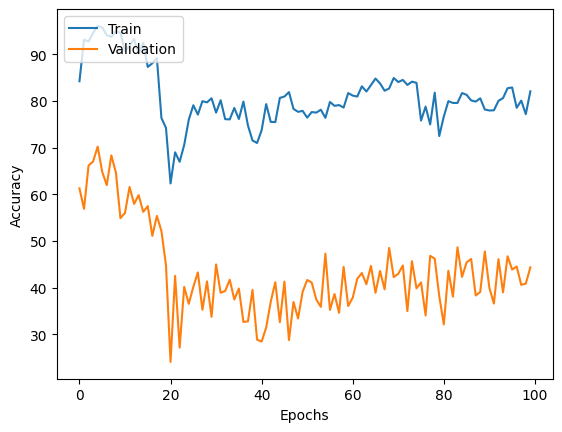

Batch Size: 128, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 89.50642886768975%, Validation Accuracy: 35.53321678321678%
Epoch 1/100 ---> Train Accuracy: 93.90294483616756%, Validation Accuracy: 65.2972027972028%
Epoch 2/100 ---> Train Accuracy: 91.53878058896723%, Validation Accuracy: 60.79545454545455%
Epoch 3/100 ---> Train Accuracy: 92.07797594359187%, Validation Accuracy: 65.16608391608392%
Epoch 4/100 ---> Train Accuracy: 87.84736623807548%, Validation Accuracy: 48.81993006993007%
Epoch 5/100 ---> Train Accuracy: 79.84238905018664%, Validation Accuracy: 32.16783216783217%
Epoch 6/100 ---> Train Accuracy: 68.85109912899212%, Validation Accuracy: 31.643356643356643%
Epoch 7/100 ---> Train Accuracy: 68.27042720862713%, Validation Accuracy: 27.22902097902098%
Epoch 8/100 ---> Train Accuracy: 59.93363749481543%, Validation Accuracy: 34.79020979020979%
Epoch 9/100 ---> Train Accuracy: 75.81916217337205%, Validation Accuracy: 25.568181818181817%
Epoch 10/100 --->

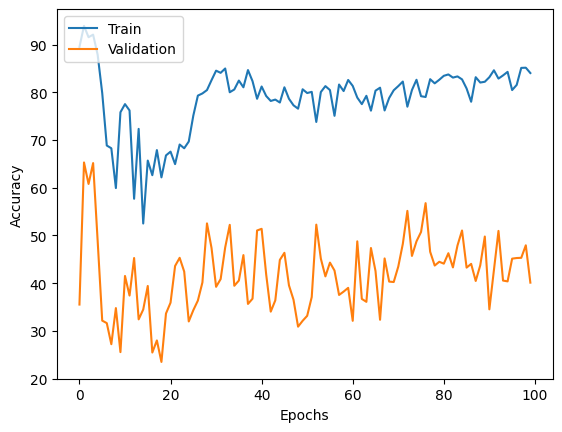

Batch Size: 256, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 15.553712152633762%, Validation Accuracy: 4.9825174825174825%
Epoch 1/100 ---> Train Accuracy: 20.116134384073%, Validation Accuracy: 6.25%
Epoch 2/100 ---> Train Accuracy: 22.438822065532975%, Validation Accuracy: 9.30944055944056%
Epoch 3/100 ---> Train Accuracy: 29.987557030277895%, Validation Accuracy: 9.659090909090908%
Epoch 4/100 ---> Train Accuracy: 34.13521360431356%, Validation Accuracy: 10.13986013986014%
Epoch 5/100 ---> Train Accuracy: 36.789713811696394%, Validation Accuracy: 10.708041958041958%
Epoch 6/100 ---> Train Accuracy: 40.107839070924925%, Validation Accuracy: 12.456293706293707%
Epoch 7/100 ---> Train Accuracy: 45.95603484031522%, Validation Accuracy: 14.685314685314685%
Epoch 8/100 ---> Train Accuracy: 51.88718374118623%, Validation Accuracy: 19.23076923076923%
Epoch 9/100 ---> Train Accuracy: 59.56034840315222%, Validation Accuracy: 20.367132867132867%
Epoch 10/100 ---> Trai

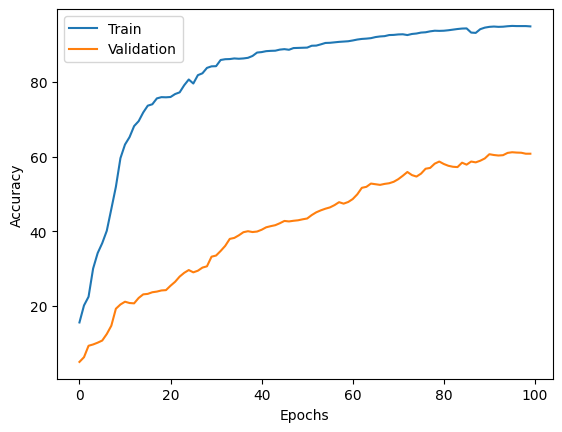

Batch Size: 256, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 16.880962256325176%, Validation Accuracy: 4.676573426573427%
Epoch 1/100 ---> Train Accuracy: 27.706345914558273%, Validation Accuracy: 6.555944055944056%
Epoch 2/100 ---> Train Accuracy: 29.365408544172542%, Validation Accuracy: 11.145104895104895%
Epoch 3/100 ---> Train Accuracy: 34.54997926171713%, Validation Accuracy: 19.667832167832167%
Epoch 4/100 ---> Train Accuracy: 39.81750311074243%, Validation Accuracy: 25.21853146853147%
Epoch 5/100 ---> Train Accuracy: 47.6980506014102%, Validation Accuracy: 26.748251748251747%
Epoch 6/100 ---> Train Accuracy: 51.63832434674409%, Validation Accuracy: 22.202797202797203%
Epoch 7/100 ---> Train Accuracy: 55.53712152633762%, Validation Accuracy: 20.498251748251747%
Epoch 8/100 ---> Train Accuracy: 59.60182496889258%, Validation Accuracy: 19.842657342657343%
Epoch 9/100 ---> Train Accuracy: 61.96598921609291%, Validation Accuracy: 19.93006993006993%
Epoch 10

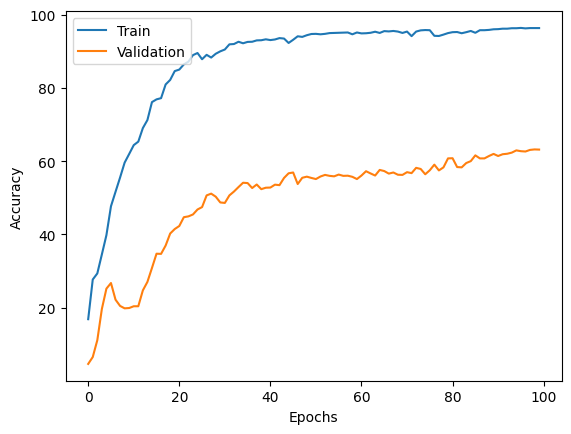

Batch Size: 256, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 22.563251762754042%, Validation Accuracy: 14.729020979020978%
Epoch 1/100 ---> Train Accuracy: 37.7436748237246%, Validation Accuracy: 18.837412587412587%
Epoch 2/100 ---> Train Accuracy: 44.58730817088345%, Validation Accuracy: 19.012237762237763%
Epoch 3/100 ---> Train Accuracy: 49.85483201990875%, Validation Accuracy: 20.585664335664337%
Epoch 4/100 ---> Train Accuracy: 53.75362919950228%, Validation Accuracy: 18.356643356643357%
Epoch 5/100 ---> Train Accuracy: 57.15470759021153%, Validation Accuracy: 15.297202797202797%
Epoch 6/100 ---> Train Accuracy: 63.91538780588967%, Validation Accuracy: 14.729020979020978%
Epoch 7/100 ---> Train Accuracy: 71.33969307341353%, Validation Accuracy: 16.127622377622377%
Epoch 8/100 ---> Train Accuracy: 74.11862297801741%, Validation Accuracy: 18.356643356643357%
Epoch 9/100 ---> Train Accuracy: 75.32144338448776%, Validation Accuracy: 17.526223776223777%
Epoch 

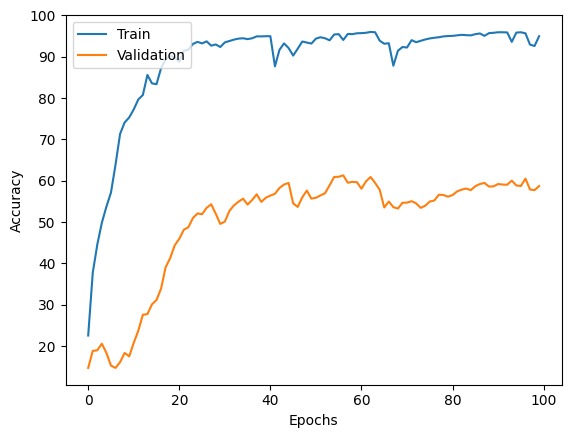

Batch Size: 256, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 44.71173786810452%, Validation Accuracy: 31.774475524475523%
Epoch 1/100 ---> Train Accuracy: 57.15470759021153%, Validation Accuracy: 30.332167832167833%
Epoch 2/100 ---> Train Accuracy: 68.72666943177104%, Validation Accuracy: 25.087412587412587%
Epoch 3/100 ---> Train Accuracy: 71.42264620489424%, Validation Accuracy: 25.874125874125873%
Epoch 4/100 ---> Train Accuracy: 76.31688096225632%, Validation Accuracy: 30.113636363636363%
Epoch 5/100 ---> Train Accuracy: 77.47822480298632%, Validation Accuracy: 30.244755244755243%
Epoch 6/100 ---> Train Accuracy: 82.78722521775197%, Validation Accuracy: 36.75699300699301%
Epoch 7/100 ---> Train Accuracy: 88.30360846121941%, Validation Accuracy: 45.8479020979021%
Epoch 8/100 ---> Train Accuracy: 91.16549149730402%, Validation Accuracy: 49.34440559440559%
Epoch 9/100 ---> Train Accuracy: 90.50186644545832%, Validation Accuracy: 49.21328671328671%
Epoch 10/100

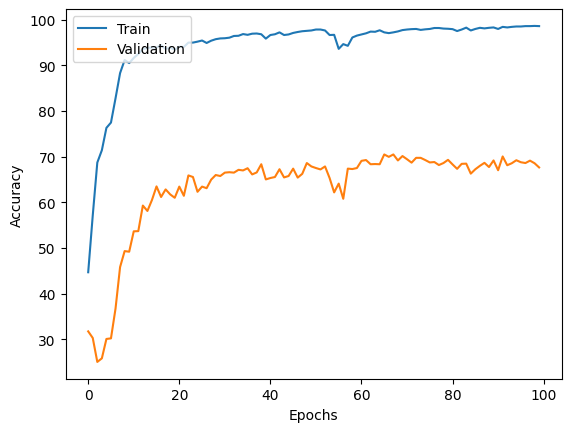

Batch Size: 256, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 61.84155951887184%, Validation Accuracy: 27.972027972027973%
Epoch 1/100 ---> Train Accuracy: 71.96184155951887%, Validation Accuracy: 22.727272727272727%
Epoch 2/100 ---> Train Accuracy: 79.2202405640813%, Validation Accuracy: 27.928321678321677%
Epoch 3/100 ---> Train Accuracy: 84.48776441310659%, Validation Accuracy: 41.82692307692308%
Epoch 4/100 ---> Train Accuracy: 90.7092492741601%, Validation Accuracy: 49.25699300699301%
Epoch 5/100 ---> Train Accuracy: 93.03193695562007%, Validation Accuracy: 54.76398601398601%
Epoch 6/100 ---> Train Accuracy: 93.07341352136044%, Validation Accuracy: 57.82342657342657%
Epoch 7/100 ---> Train Accuracy: 95.14724180837827%, Validation Accuracy: 63.11188811188811%
Epoch 8/100 ---> Train Accuracy: 94.40066362505185%, Validation Accuracy: 64.33566433566433%
Epoch 9/100 ---> Train Accuracy: 90.79220240564081%, Validation Accuracy: 53.54020979020979%
Epoch 10/100 ---

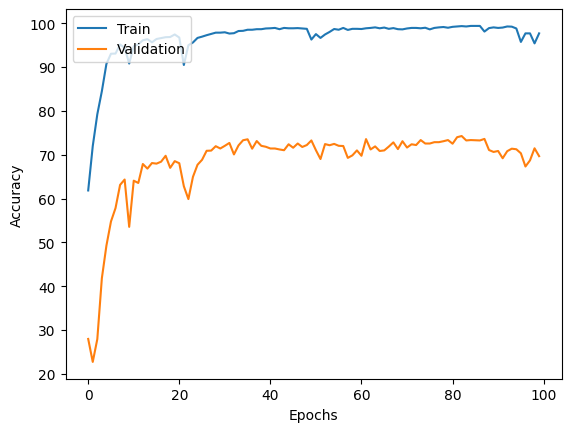

Batch Size: 256, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 62.33927830775612%, Validation Accuracy: 24.86888111888112%
Epoch 1/100 ---> Train Accuracy: 83.53380340107839%, Validation Accuracy: 37.89335664335665%
Epoch 2/100 ---> Train Accuracy: 88.8013272501037%, Validation Accuracy: 42.30769230769231%
Epoch 3/100 ---> Train Accuracy: 92.70012442969723%, Validation Accuracy: 44.79895104895105%
Epoch 4/100 ---> Train Accuracy: 93.36374948154292%, Validation Accuracy: 53.80244755244755%
Epoch 5/100 ---> Train Accuracy: 91.53878058896723%, Validation Accuracy: 53.75874125874126%
Epoch 6/100 ---> Train Accuracy: 92.32683533803402%, Validation Accuracy: 53.19055944055944%
Epoch 7/100 ---> Train Accuracy: 93.5711323102447%, Validation Accuracy: 60.97027972027972%
Epoch 8/100 ---> Train Accuracy: 92.49274160099544%, Validation Accuracy: 59.7027972027972%
Epoch 9/100 ---> Train Accuracy: 95.10576524263791%, Validation Accuracy: 65.12237762237763%
Epoch 10/100 ---> Tr

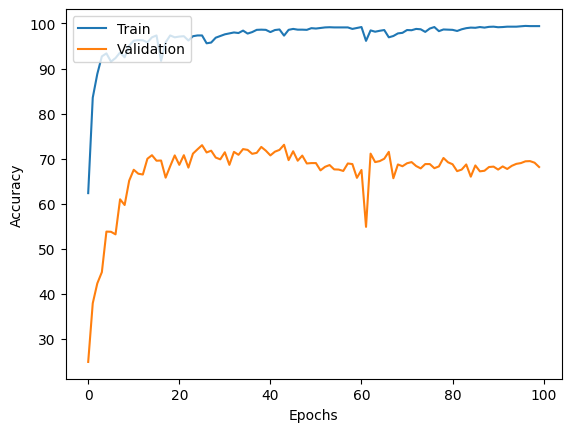

Batch Size: 256, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 77.18788884280382%, Validation Accuracy: 21.503496503496503%
Epoch 1/100 ---> Train Accuracy: 91.87059311489008%, Validation Accuracy: 51.18006993006993%
Epoch 2/100 ---> Train Accuracy: 94.52509332227291%, Validation Accuracy: 58.56643356643357%
Epoch 3/100 ---> Train Accuracy: 94.52509332227291%, Validation Accuracy: 61.84440559440559%
Epoch 4/100 ---> Train Accuracy: 94.93985897967649%, Validation Accuracy: 60.97027972027972%
Epoch 5/100 ---> Train Accuracy: 95.35462463708005%, Validation Accuracy: 59.57167832167832%
Epoch 6/100 ---> Train Accuracy: 94.64952301949398%, Validation Accuracy: 63.81118881118881%
Epoch 7/100 ---> Train Accuracy: 96.76482787225218%, Validation Accuracy: 68.00699300699301%
Epoch 8/100 ---> Train Accuracy: 96.84778100373289%, Validation Accuracy: 70.1486013986014%
Epoch 9/100 ---> Train Accuracy: 96.80630443799254%, Validation Accuracy: 66.91433566433567%
Epoch 10/100 ---> 

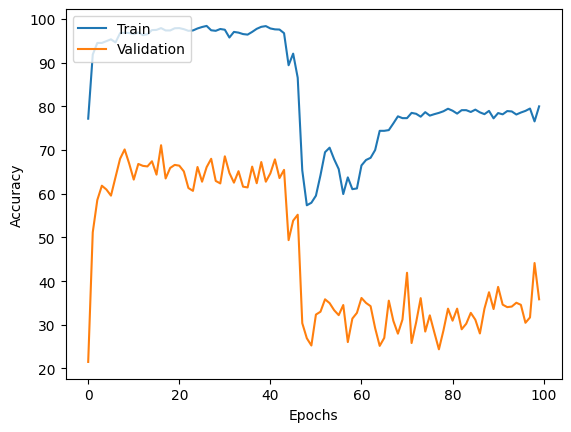

Batch Size: 256, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 83.45085026959768%, Validation Accuracy: 44.4493006993007%
Epoch 1/100 ---> Train Accuracy: 91.16549149730402%, Validation Accuracy: 58.65384615384615%
Epoch 2/100 ---> Train Accuracy: 92.90750725839901%, Validation Accuracy: 62.23776223776224%
Epoch 3/100 ---> Train Accuracy: 92.2438822065533%, Validation Accuracy: 57.16783216783217%
Epoch 4/100 ---> Train Accuracy: 94.48361675653256%, Validation Accuracy: 58.3479020979021%
Epoch 5/100 ---> Train Accuracy: 95.35462463708005%, Validation Accuracy: 62.45629370629371%
Epoch 6/100 ---> Train Accuracy: 96.05972625466612%, Validation Accuracy: 63.37412587412587%
Epoch 7/100 ---> Train Accuracy: 96.43301534632933%, Validation Accuracy: 62.89335664335665%
Epoch 8/100 ---> Train Accuracy: 97.05516383243467%, Validation Accuracy: 65.42832167832168%
Epoch 9/100 ---> Train Accuracy: 87.34964744919121%, Validation Accuracy: 40.16608391608391%
Epoch 10/100 ---> Tra

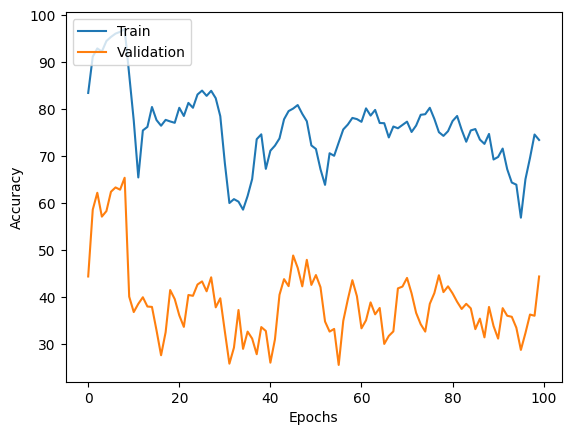

Batch Size: 256, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 81.29406885109913%, Validation Accuracy: 46.15384615384615%
Epoch 1/100 ---> Train Accuracy: 91.6632102861883%, Validation Accuracy: 53.27797202797203%
Epoch 2/100 ---> Train Accuracy: 94.19328079635007%, Validation Accuracy: 55.76923076923077%
Epoch 3/100 ---> Train Accuracy: 95.35462463708005%, Validation Accuracy: 63.76748251748252%
Epoch 4/100 ---> Train Accuracy: 94.64952301949398%, Validation Accuracy: 68.1381118881119%
Epoch 5/100 ---> Train Accuracy: 95.35462463708005%, Validation Accuracy: 63.15559440559441%
Epoch 6/100 ---> Train Accuracy: 95.9767731231854%, Validation Accuracy: 63.94230769230769%
Epoch 7/100 ---> Train Accuracy: 94.60804645375363%, Validation Accuracy: 68.31293706293707%
Epoch 8/100 ---> Train Accuracy: 95.47905433430113%, Validation Accuracy: 60.79545454545455%
Epoch 9/100 ---> Train Accuracy: 92.99046038987971%, Validation Accuracy: 60.53321678321678%
Epoch 10/100 ---> Tra

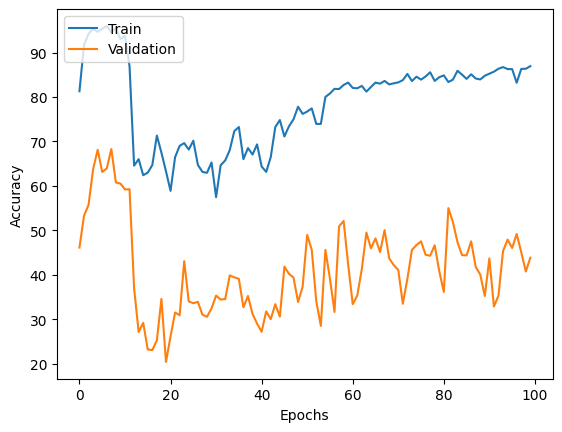

Batch Size: 512, Learning Rate: 0.001, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 6.885109912899212%, Validation Accuracy: 1.3986013986013985%
Epoch 1/100 ---> Train Accuracy: 9.124844462878473%, Validation Accuracy: 1.5297202797202798%
Epoch 2/100 ---> Train Accuracy: 12.401493156366653%, Validation Accuracy: 2.4038461538461537%
Epoch 3/100 ---> Train Accuracy: 16.798009124844462%, Validation Accuracy: 3.409090909090909%
Epoch 4/100 ---> Train Accuracy: 20.447946909995853%, Validation Accuracy: 3.977272727272727%
Epoch 5/100 ---> Train Accuracy: 24.38822065532974%, Validation Accuracy: 4.195804195804196%
Epoch 6/100 ---> Train Accuracy: 28.78473662380755%, Validation Accuracy: 4.8076923076923075%
Epoch 7/100 ---> Train Accuracy: 32.144338448776445%, Validation Accuracy: 6.381118881118881%
Epoch 8/100 ---> Train Accuracy: 34.25964330153463%, Validation Accuracy: 7.473776223776224%
Epoch 9/100 ---> Train Accuracy: 37.08004977187889%, Validation Accuracy: 8.12937062937063%
Epoch 10/

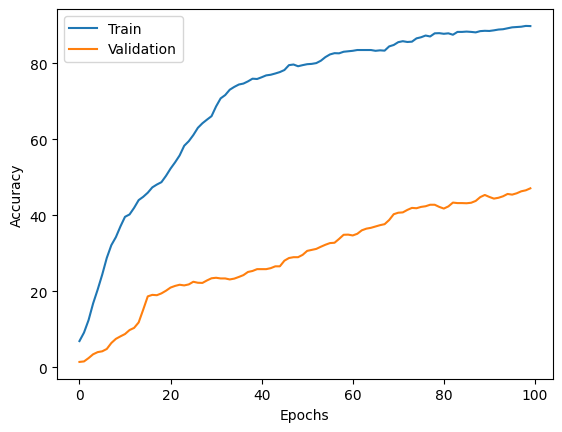

Batch Size: 512, Learning Rate: 0.001, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 8.751555371215263%, Validation Accuracy: 2.8846153846153846%
Epoch 1/100 ---> Train Accuracy: 10.078805474906678%, Validation Accuracy: 3.7587412587412588%
Epoch 2/100 ---> Train Accuracy: 19.867274989630857%, Validation Accuracy: 6.206293706293707%
Epoch 3/100 ---> Train Accuracy: 24.59560348403152%, Validation Accuracy: 6.818181818181818%
Epoch 4/100 ---> Train Accuracy: 36.45790128577354%, Validation Accuracy: 7.77972027972028%
Epoch 5/100 ---> Train Accuracy: 41.35213604313563%, Validation Accuracy: 10.052447552447552%
Epoch 6/100 ---> Train Accuracy: 43.71630029033596%, Validation Accuracy: 10.402097902097902%
Epoch 7/100 ---> Train Accuracy: 46.86851928660307%, Validation Accuracy: 10.48951048951049%
Epoch 8/100 ---> Train Accuracy: 48.94234757362091%, Validation Accuracy: 11.145104895104895%
Epoch 9/100 ---> Train Accuracy: 53.42181667357943%, Validation Accuracy: 11.713286713286713%
Epoch 10/

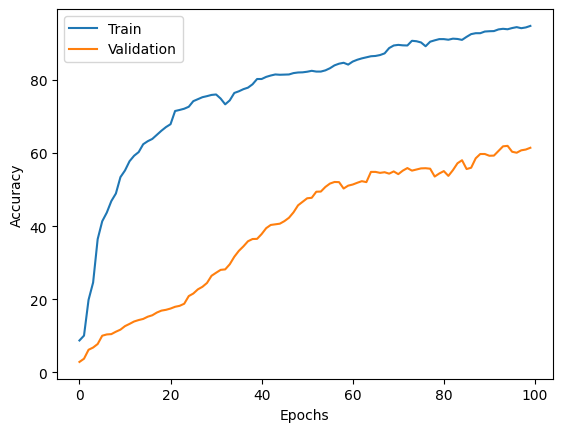

Batch Size: 512, Learning Rate: 0.001, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 18.540024885939445%, Validation Accuracy: 35.13986013986014%
Epoch 1/100 ---> Train Accuracy: 25.300705101617584%, Validation Accuracy: 44.36188811188811%
Epoch 2/100 ---> Train Accuracy: 31.93695562007466%, Validation Accuracy: 47.63986013986014%
Epoch 3/100 ---> Train Accuracy: 34.59145582745749%, Validation Accuracy: 44.66783216783217%
Epoch 4/100 ---> Train Accuracy: 40.93737038573206%, Validation Accuracy: 40.86538461538461%
Epoch 5/100 ---> Train Accuracy: 46.287847366238076%, Validation Accuracy: 36.97552447552447%
Epoch 6/100 ---> Train Accuracy: 49.85483201990875%, Validation Accuracy: 30.244755244755243%
Epoch 7/100 ---> Train Accuracy: 51.721277478224806%, Validation Accuracy: 24.65034965034965%
Epoch 8/100 ---> Train Accuracy: 57.69390294483617%, Validation Accuracy: 21.153846153846153%
Epoch 9/100 ---> Train Accuracy: 61.17793446702613%, Validation Accuracy: 20.585664335664337%
Epoch 10/

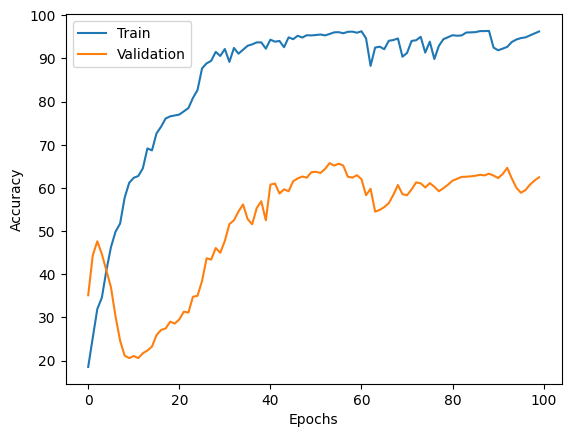

Batch Size: 512, Learning Rate: 0.01, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 35.877229365408546%, Validation Accuracy: 7.561188811188811%
Epoch 1/100 ---> Train Accuracy: 37.4533388635421%, Validation Accuracy: 8.304195804195805%
Epoch 2/100 ---> Train Accuracy: 48.77644131065948%, Validation Accuracy: 12.456293706293707%
Epoch 3/100 ---> Train Accuracy: 64.28867689755289%, Validation Accuracy: 15.996503496503497%
Epoch 4/100 ---> Train Accuracy: 72.50103691414351%, Validation Accuracy: 17.526223776223777%
Epoch 5/100 ---> Train Accuracy: 78.14184985483202%, Validation Accuracy: 20.454545454545453%
Epoch 6/100 ---> Train Accuracy: 79.38614682704272%, Validation Accuracy: 22.50874125874126%
Epoch 7/100 ---> Train Accuracy: 82.99460804645375%, Validation Accuracy: 24.125874125874127%
Epoch 8/100 ---> Train Accuracy: 83.57527996681874%, Validation Accuracy: 25.96153846153846%
Epoch 9/100 ---> Train Accuracy: 83.2434674408959%, Validation Accuracy: 29.895104895104897%
Epoch 10/100

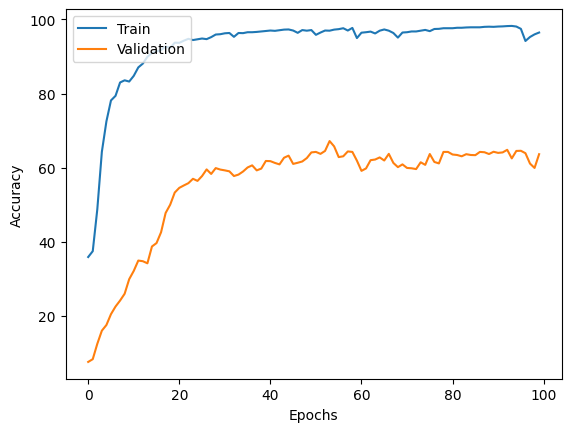

Batch Size: 512, Learning Rate: 0.01, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 38.82206553297387%, Validation Accuracy: 9.178321678321678%
Epoch 1/100 ---> Train Accuracy: 47.32476150974699%, Validation Accuracy: 11.276223776223777%
Epoch 2/100 ---> Train Accuracy: 60.68021567814185%, Validation Accuracy: 12.762237762237762%
Epoch 3/100 ---> Train Accuracy: 66.32102861883035%, Validation Accuracy: 14.554195804195805%
Epoch 4/100 ---> Train Accuracy: 72.33513065118208%, Validation Accuracy: 16.60839160839161%
Epoch 5/100 ---> Train Accuracy: 79.67648278722521%, Validation Accuracy: 20.27972027972028%
Epoch 6/100 ---> Train Accuracy: 86.52011613438407%, Validation Accuracy: 28.54020979020979%
Epoch 7/100 ---> Train Accuracy: 88.59394442140191%, Validation Accuracy: 35.05244755244755%
Epoch 8/100 ---> Train Accuracy: 89.87971795935296%, Validation Accuracy: 39.07342657342657%
Epoch 9/100 ---> Train Accuracy: 91.04106180008296%, Validation Accuracy: 46.41608391608391%
Epoch 10/100 -

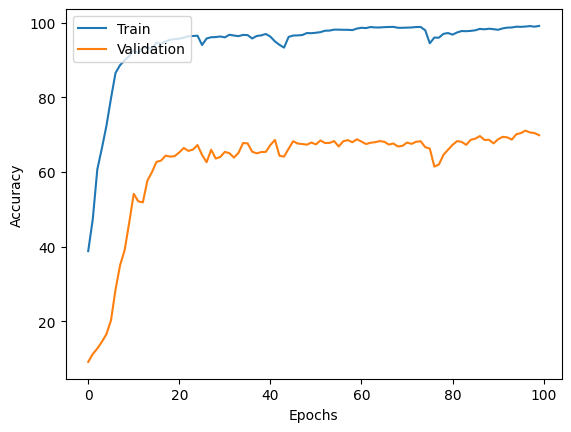

Batch Size: 512, Learning Rate: 0.01, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 36.08461219411033%, Validation Accuracy: 12.281468531468532%
Epoch 1/100 ---> Train Accuracy: 63.002903359601824%, Validation Accuracy: 16.38986013986014%
Epoch 2/100 ---> Train Accuracy: 72.87432600580672%, Validation Accuracy: 27.666083916083917%
Epoch 3/100 ---> Train Accuracy: 81.29406885109913%, Validation Accuracy: 40.12237762237762%
Epoch 4/100 ---> Train Accuracy: 86.47863956864371%, Validation Accuracy: 49.60664335664335%
Epoch 5/100 ---> Train Accuracy: 88.75985068436333%, Validation Accuracy: 55.98776223776224%
Epoch 6/100 ---> Train Accuracy: 91.04106180008296%, Validation Accuracy: 56.33741258741259%
Epoch 7/100 ---> Train Accuracy: 93.07341352136044%, Validation Accuracy: 61.66958041958042%
Epoch 8/100 ---> Train Accuracy: 94.98133554541684%, Validation Accuracy: 64.29195804195804%
Epoch 9/100 ---> Train Accuracy: 95.43757776856076%, Validation Accuracy: 64.64160839160839%
Epoch 10/100 -

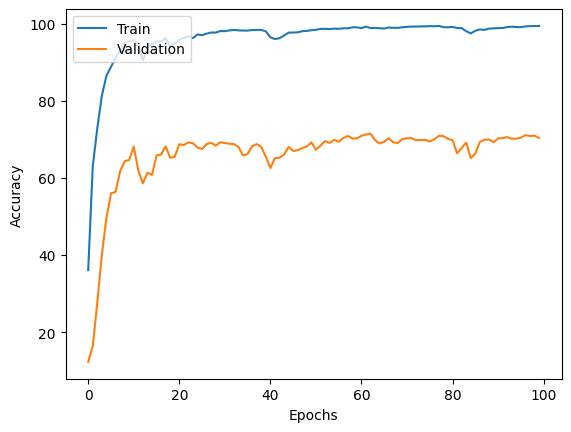

Batch Size: 512, Learning Rate: 0.1, Hidden Dim: 16
Epoch 0/100 ---> Train Accuracy: 59.60182496889258%, Validation Accuracy: 18.181818181818183%
Epoch 1/100 ---> Train Accuracy: 78.26627955205309%, Validation Accuracy: 22.115384615384617%
Epoch 2/100 ---> Train Accuracy: 87.30817088345086%, Validation Accuracy: 38.46153846153846%
Epoch 3/100 ---> Train Accuracy: 91.6632102861883%, Validation Accuracy: 45.27972027972028%
Epoch 4/100 ---> Train Accuracy: 93.94442140190792%, Validation Accuracy: 56.25%
Epoch 5/100 ---> Train Accuracy: 94.3591870593115%, Validation Accuracy: 57.56118881118881%
Epoch 6/100 ---> Train Accuracy: 95.93529655744504%, Validation Accuracy: 61.58216783216783%
Epoch 7/100 ---> Train Accuracy: 96.01824968892576%, Validation Accuracy: 64.33566433566433%
Epoch 8/100 ---> Train Accuracy: 95.93529655744504%, Validation Accuracy: 65.47202797202797%
Epoch 9/100 ---> Train Accuracy: 96.47449191206968%, Validation Accuracy: 66.56468531468532%
Epoch 10/100 ---> Train Accura

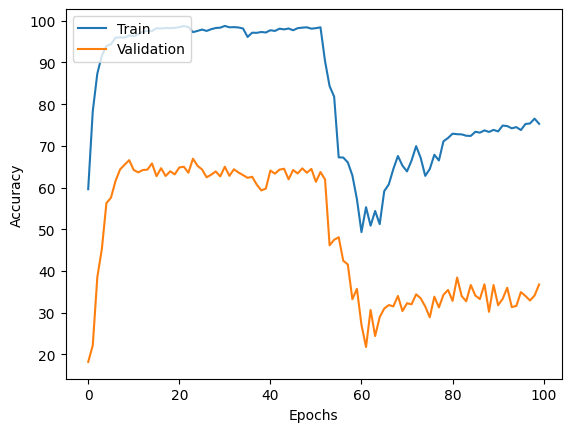

Batch Size: 512, Learning Rate: 0.1, Hidden Dim: 32
Epoch 0/100 ---> Train Accuracy: 78.18332642057237%, Validation Accuracy: 25.305944055944057%
Epoch 1/100 ---> Train Accuracy: 84.15595188718375%, Validation Accuracy: 55.15734265734266%
Epoch 2/100 ---> Train Accuracy: 91.78763998340938%, Validation Accuracy: 57.03671328671329%
Epoch 3/100 ---> Train Accuracy: 94.56656988801328%, Validation Accuracy: 65.16608391608392%
Epoch 4/100 ---> Train Accuracy: 95.35462463708005%, Validation Accuracy: 66.21503496503496%
Epoch 5/100 ---> Train Accuracy: 95.81086686022397%, Validation Accuracy: 67.3951048951049%
Epoch 6/100 ---> Train Accuracy: 96.76482787225218%, Validation Accuracy: 68.7062937062937%
Epoch 7/100 ---> Train Accuracy: 97.30402322687681%, Validation Accuracy: 69.62412587412588%
Epoch 8/100 ---> Train Accuracy: 97.63583575279966%, Validation Accuracy: 68.35664335664336%
Epoch 9/100 ---> Train Accuracy: 97.84321858150145%, Validation Accuracy: 66.52097902097903%
Epoch 10/100 ---> T

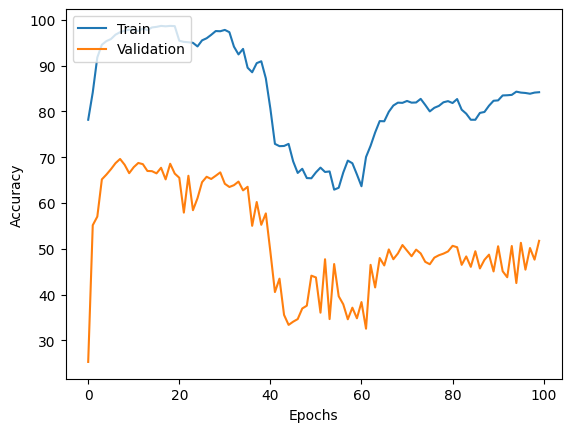

Batch Size: 512, Learning Rate: 0.1, Hidden Dim: 64
Epoch 0/100 ---> Train Accuracy: 72.791372874326%, Validation Accuracy: 18.138111888111887%
Epoch 1/100 ---> Train Accuracy: 86.22978017420158%, Validation Accuracy: 50.52447552447553%
Epoch 2/100 ---> Train Accuracy: 91.45582745748652%, Validation Accuracy: 54.41433566433567%
Epoch 3/100 ---> Train Accuracy: 94.52509332227291%, Validation Accuracy: 60.83916083916084%
Epoch 4/100 ---> Train Accuracy: 94.81542928245541%, Validation Accuracy: 59.13461538461539%
Epoch 5/100 ---> Train Accuracy: 95.35462463708005%, Validation Accuracy: 63.06818181818182%
Epoch 6/100 ---> Train Accuracy: 94.98133554541684%, Validation Accuracy: 61.62587412587413%
Epoch 7/100 ---> Train Accuracy: 91.53878058896723%, Validation Accuracy: 59.74650349650349%
Epoch 8/100 ---> Train Accuracy: 94.06885109912899%, Validation Accuracy: 62.71853146853147%
Epoch 9/100 ---> Train Accuracy: 95.06428867689755%, Validation Accuracy: 62.45629370629371%
Epoch 10/100 ---> T

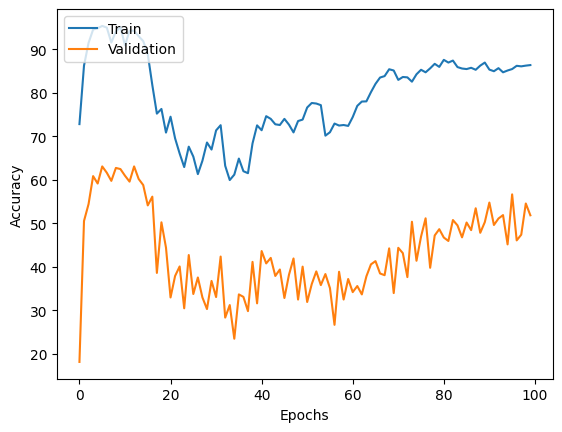

In [14]:

# Hyperparameter Tuning
EPOCHS = 100

for BATCH_SIZE in [128, 256, 512]:
    for LEARNING_RATE in [0.001, 0.01, 0.1]:
        for HIDDEN_DIM in [16, 32, 64]:
            print(f'Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE}, Hidden Dim: {HIDDEN_DIM}')
            train_accuracy_list, validation_accuracy_list = modelLoop(EPOCHS, HIDDEN_DIM, LEARNING_RATE, BATCH_SIZE)
            plot_acc(train_accuracy_list, validation_accuracy_list)